# Classification of 2D Ising model phase using Neural Networks

This notebook shows our implementation of a neural network in action on predicting the phase of the 2D Ising model. 

In [3]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit

from project2_tools import get_2Ddata, to_onehot, from_onehot, get_data_sigmoid
from neuralnet import NeuralNet
from plotting import PlotWrap
plotter = PlotWrap(savefigs=True) # set to False to stop saving

# Load and split data 

Loads data from Mehta et. al. [1]

In [6]:
data_input, data_targets = get_2Ddata(t_crit = 2.3, onehot = True)

from sklearn.model_selection import train_test_split
temp = train_test_split(data_input, data_targets, test_size = 0.33)
input_train, input_test, target_train, target_test = temp

## Setup network and run. Warning, this takes time

`run_minibatch_sgd` trains networks using minibatch stochastic gradient descent with a given number of hidden layers and other hyperparameters. Multiple parameters can be set, see the docstring of `run_minbatch_sgd`:

In [41]:
from result_functions import run_minibatch_sgd as sgd
? sgd

In [404]:
n_hidden_values = [8, 10, 16, 20, 32, 64, 96, 128]
eta_values = np.logspace(-2,2,9)

sgd(input_train,target_train, input_test, target_test, eta_values = eta_values,  n_hidden_values = n_hidden_values)

n hidden nodes:  128
eta:  100.0
batch size:  10
batch, epoch, accuracy
 9000/10000     41/100  0.96
Time estimate: 35701 seconds left
earlystop at epoch number 42


run this to show docstring

In [10]:
? sgd

# Load premade data

`distribute.py` has some nice manual parallelization for running calculations on several computers through ssh. Given a host list, it distributes the eta-values. We are truly sorry for the extreme mess in the data files, however.

In [20]:
import glob
files = glob.glob('output/mb_sgd*.pickle')
files

['output/mb_sgdregrgeigerteller_3.pickle',
 'output/mb_sgdregr_siglikning_0.pickle',
 'output/mb_sgdmikroprosessor_0.pickle',
 'output/mb_sgdregrspole_2.pickle',
 'output/mb_sgd2_relu.pickle',
 'output/mb_sgdregrlikning_2.pickle',
 'output/mb_sgdregrlaser_1.pickle',
 'output/mb_sgdregrlaser_0.pickle',
 'output/mb_sgdregr_sigkretskort_0.pickle',
 'output/mb_sgdregrscintillator_0.pickle',
 'output/mb_sgdforsterker_0.pickle',
 'output/mb_sgdregrspole_0.pickle',
 'output/mb_sgdregr_sig_likning_0.pickle',
 'output/mb_sgdregrlikning_1.pickle',
 'output/mb_sgdregr_sig_scintillator_1.pickle',
 'output/mb_sgdscintillator_0.pickle',
 'output/mb_sgdregr_sig_kretskort_0.pickle',
 'output/mb_sgdgeigerteller_0.pickle',
 'output/mb_sgdregrkretskort_2.pickle',
 'output/mb_sgdregr_sig_kretskort_3.pickle',
 'output/mb_sgdregr_sig_laser_1.pickle',
 'output/mb_sgdregr_siglaser_0.pickle',
 'output/mb_sgdregrlikning_0.pickle',
 'output/mb_sgdregr_siglikning_1.pickle',
 'output/mb_sgdregrmultimeter_1.pickle'

# Example of how data looks

In [15]:
df = pd.read_pickle(files[4])
df['eta_val'] = np.log10(df['eta'])
df.head()

,accuracy,epochs,eta,n_batches,nhidden,final_accuracy,max_accuracy,eta_val
0,"[0.5620833333333334, 0.5620833333333334, 0.562...",41,10.0,10000,8,0.562083,0.562083,1.0
1,"[0.5620833333333334, 0.5620833333333334, 0.562...",41,10.0,10000,10,0.562083,0.562083,1.0
2,"[0.5620833333333334, 0.5620833333333334, 0.562...",41,10.0,10000,16,0.562083,0.562083,1.0
3,"[0.5620833333333334, 0.5620833333333334, 0.562...",41,10.0,10000,20,0.562083,0.562083,1.0
4,"[0.5620833333333334, 0.5620833333333334, 0.562...",41,10.0,10000,32,0.562083,0.562083,1.0


### Push sigmoid  data into nicer format

In [21]:
def eta_nhidden_df(df):
    temp = df[['nhidden','eta','max_accuracy']]
    temp = temp.set_index(['nhidden','eta'],drop=True).unstack()
    temp.columns = temp.columns.droplevel(level=0)
    temp.columns = np.log10(temp.columns)
    return temp

In [24]:

dfs_sigmoid = [pd.read_pickle(f) for f in files if 'sigmoid' in f]
data_sigmoid = [eta_nhidden_df(d) for d in dfs_sigmoid]
# dfs_sigmoid[2] = dfs_sigmoid[2][np.log10(dfs_sigmoid[2]['eta']) != -0.5]
dfs_sigmoid[1] = dfs_sigmoid[1][np.log10(dfs_sigmoid[1]['eta']) != -0.5]

d1,d2,d3 = dfs_sigmoid
eta_vals = np.linspace(-2, 2, 9)
for d in [d1,d2,d3]:
    d['eta_val'] = np.log10(d.eta)

for i, old in enumerate(np.unique(d1.eta_val)):
    d1.loc[d1['eta_val'] == old, 'eta_val'] = eta_vals[i]
    
    
for i, old in enumerate(np.unique(d2.eta_val)):
    d2.loc[d2['eta_val'] == old, 'eta_val'] = eta_vals[i+5]
    
d1.eta = 10**d1.eta_val
d2.eta = 10**d2.eta_val
dfs_sigmoid = [d1,d2,d3]

### load and amend rest of the data files, and convert to nice format

In [30]:
pcer = [line.rstrip() for line in open('/home/halvard/pcer.txt')]
tanh_files = ['mb_sgd{}_0.pickle'.format(pc) for pc in pcer]
df_tanh = pd.concat([pd.read_pickle(f) for f in files if f.split('/')[-1] in tanh_files], ignore_index = True)
df_relu = pd.concat([pd.read_pickle(f) for f in files if 'relu' in f], ignore_index = True)
df_sigmoid = pd.concat(dfs_sigmoid,ignore_index = True)

# nice format
data_relu = eta_nhidden_df(df_relu) 
data_tanh = eta_nhidden_df(df_tanh) 

for df in [df_relu, df_sigmoid, df_tanh]:
    df['eta_val'] = np.log10(df['eta'])
    df['optimal_epoch'] = df['accuracy'].apply(np.argmax)+1
    
df_relu['hidden_act'] = 'relu'
df_tanh['hidden_act'] = 'tanh'
df_sigmoid['hidden_act'] = 'sigmoid'



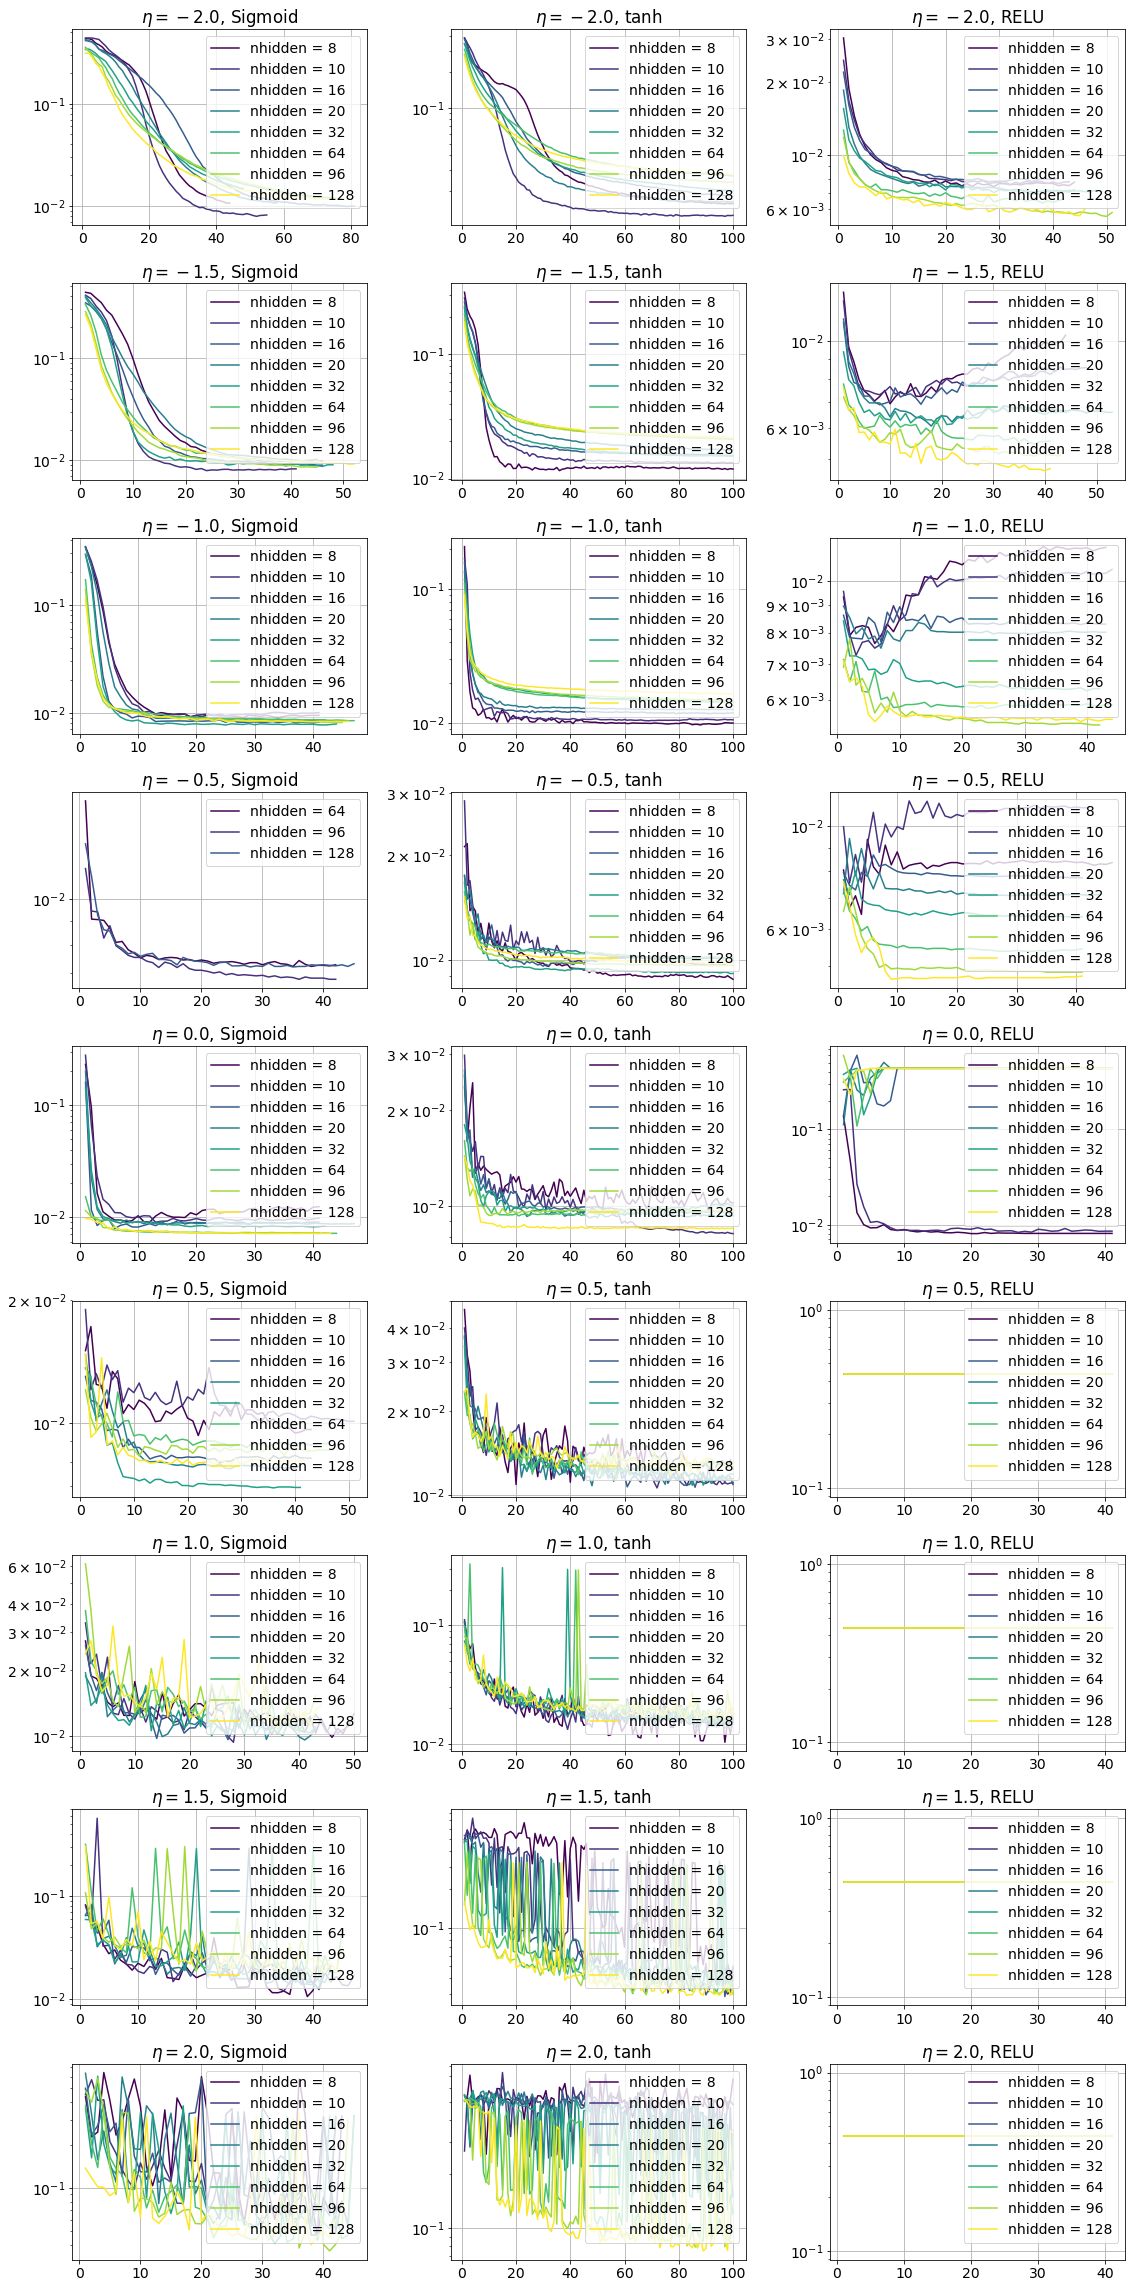

In [36]:
num_rows = np.unique(df_sigmoid.eta_val).size

fig, axes = plt.subplots(num_rows,3, figsize = [16,32])
axes_T = [ax_row for ax_row in zip(*axes)]

names = ['Sigmoid', 'tanh', 'RELU']

df = df_sigmoid
for df, ax_col, name in zip([df_sigmoid, df_tanh, df_relu], axes_T, names):

    n_hidden_values = np.unique(df.nhidden)
    colors = plt.cm.viridis(np.linspace(0,1,len(n_hidden_values)))


    for i,(eta, item) in enumerate(df.groupby('eta_val')):
        ax = ax_col[i]

        ax.set_title('$\eta = {}$, {}'.format(eta, name))
        
        for (nhidden, item), c in zip(item.groupby('nhidden'),colors):


            if True:#eta == 0.1:
                y =  1-np.array(item['accuracy'].values[0])
                eta_val = item['eta_val'].iloc[0]
                ax.semilogy(np.arange(y.size) + 1  , y, label = 'nhidden = {}'.format(nhidden), c= c, linestyle = '-')
            # print(y[-1])

        ax.grid()
        ax.legend()

fig.tight_layout()

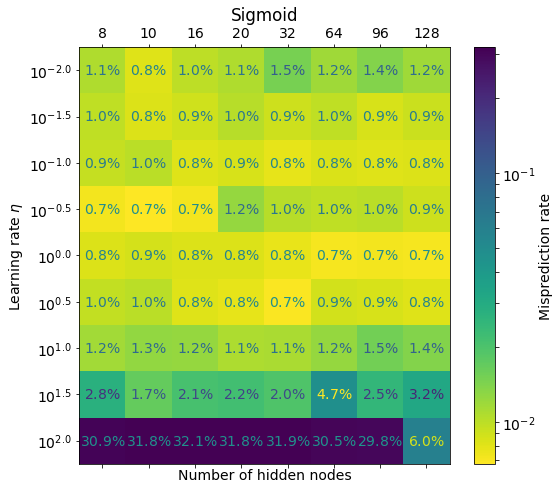

In [1227]:
# plt.imshow(data)

x = nhidden_values
y = eta_values

plotter.plot_mispred(data_sigmoid, x, y, title = 'Sigmoid', filename = 'mispred_sigmoid')


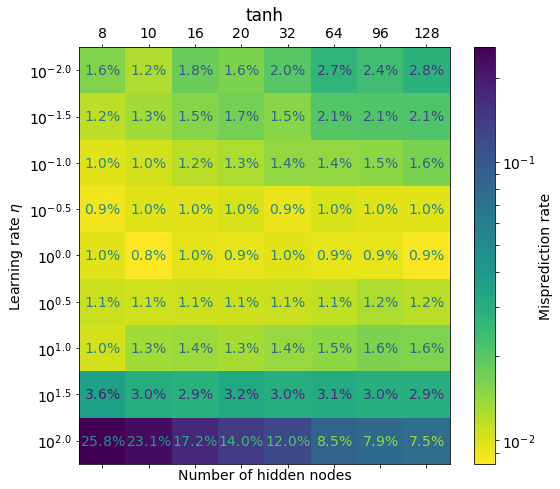

In [1228]:
x = data_tanh.index
y = data_tanh.columns
plotter.plot_mispred(data_tanh.values.T, x, y, title = 'tanh', filename = 'mispred_tanh')

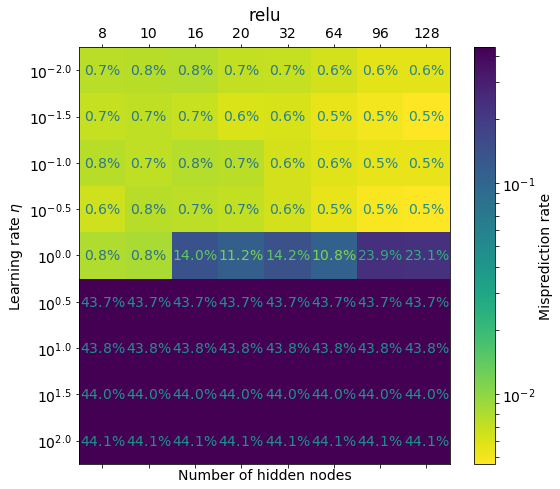

In [1229]:
x = data_relu.index
y = data_relu.columns
plotter.plot_mispred(data_relu.values.T, x, y, title = 'relu', filename = 'mispred_relu')

# Plot a nice value

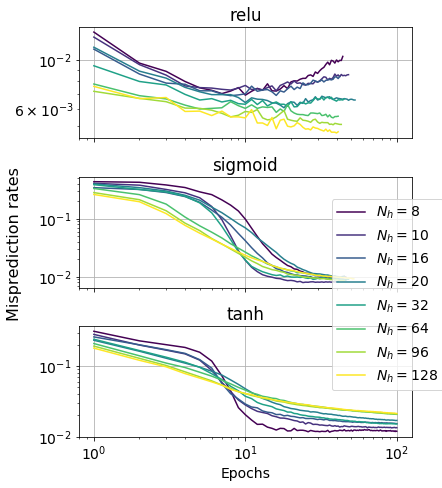

In [37]:
super_df = pd.concat([df_sigmoid, df_relu, df_tanh], ignore_index= True)
plotter.plot_eta_compare(super_df, eta_val = -1.5)

# Collect best parameters in a latex table

In [38]:
from collections import defaultdict
from plotting import gen_best_table
print(gen_best_table([df_relu, df_sigmoid, df_tanh]))

\begin{tabular}{llrrlrrlrr}
\toprule
{} & \multicolumn{3}{l}{relu} & \multicolumn{3}{l}{sig} & \multicolumn{3}{l}{tanh} \\
{} &     $\eta$ & Accuracy & Epoch &     $\eta$ & Accuracy & Epoch &     $\eta$ & Accuracy & Epoch \\
$N_h$ &            &          &       &            &          &       &            &          &       \\
\midrule
8     &  10^{-0.5} &    0.994 &     4 &  10^{-1.0} &    0.991 &    28 &  10^{-0.5} &    0.991 &   100 \\
10    &  10^{-1.5} &    0.993 &    16 &  10^{-2.0} &    0.992 &    52 &   10^{0.0} &    0.992 &   100 \\
16    &  10^{-1.5} &    0.993 &     8 &   10^{0.0} &    0.992 &     6 &   10^{0.0} &    0.990 &    83 \\
20    &  10^{-1.5} &    0.994 &    18 &   10^{0.5} &    0.992 &    28 &   10^{0.0} &    0.991 &    47 \\
32    &  10^{-1.5} &    0.994 &    21 &   10^{0.5} &    0.993 &    36 &  10^{-0.5} &    0.991 &    99 \\
64    &  10^{-0.5} &    0.995 &    27 &   10^{0.0} &    0.993 &    41 &   10^{0.0} &    0.991 &    21 \\
96    &  10^{-0.5} &    0.995 &

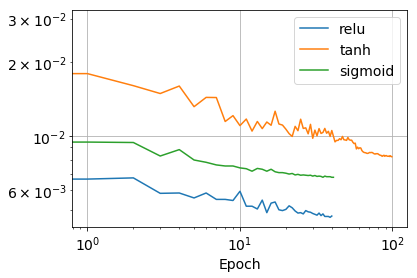

In [40]:
best_three = pd.concat([df.iloc[df.max_accuracy.idxmax()] for df in [df_relu, df_tanh, df_sigmoid]],axis = 1).T
best_three = best_three.set_index('hidden_act', drop = True)

for hact, item in best_three.T.items():
    y = 1-np.array(item['accuracy'])
    epoch = np.arange(len(y))
    plt.loglog(epoch, y, label = hact)
    
plt.xlabel('Epoch')
plt.grid()
plt.legend()

### References
    